In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12)

from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Masking

from keras import optimizers
from keras import models
from attention.layers import AttentionLayer

Using TensorFlow backend.


# Generating the dataset

Each sample is a "tape" formed by two rows: the top row $y[0]$ contains random numbers sampled from the interval $[0, 1)$, while the second, $y[1]$, is formed by a string of zeros, except for one position, which has a one. The model is trained as a regressor to produce on the output the value from the first row of the column marked as 1. For example, given:

$$ y = 
\begin{bmatrix}
    0.13 & 0.01 & 0.11 & 0.32 & 0.24 & 0.01 \\
    0    & 0    & 0    & 0    &   1  & 0    \\
\end{bmatrix},
$$

the model should produce $\mathcal{M}_\theta(y) = 0.24$. We train two models, one without attention and other with, as shown below.

In [2]:
N_SAMPLES = 1000
TIMESTEPS = 64

# (b, t, d)
X = np.random.rand(N_SAMPLES, TIMESTEPS, 1)
F = np.zeros(shape=(N_SAMPLES, TIMESTEPS, 1))
X = np.concatenate((X, F), axis=2)

Y = list()

correct_timesteps = np.random.randint(low=0, high=TIMESTEPS, size=(N_SAMPLES))
for sample, timestep in enumerate(correct_timesteps):
    X[sample][timestep][1] = 1
    
    Y.append(X[sample][timestep][0])
    
Y = np.asarray(Y).reshape(-1, 1)

# Defining a simple and an attention model

In [3]:
def build_vanilla_model():
    model_in = Input(shape=(TIMESTEPS, 2), name='sequence-in')
    vectors  = LSTM(units=4, name='lstm')(model_in)
    output   = Dense(units=1, activation='linear')(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()

    model.compile(optimizers.Adam(1e-2), 'mse', metrics=['mse'])
    return model


def build_attention_model():
    model_in = Input(shape=(None, 2), name='sequence-in')
    masked   = Masking(name='mask')(model_in)
    vectors  = LSTM(units=4, name='lstm', return_sequences=True)(masked)

    descr    = AttentionLayer(name='attention')(vectors)
    output   = Dense(units=1, activation='linear')(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()

    model.compile(optimizers.Adam(5e-2), 'mse', metrics=['mse'])
    return model

# Training them

In [4]:
vanilla_model = build_vanilla_model()
vanilla_model.fit(X, Y, batch_size=32, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     (None, 64, 2)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1473 - mean_squared_error: 0.1473
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0868 - mean_squared_error: 0.0868
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - lo

In [5]:
attention_model = build_attention_model()
attention_model.predict(X).shape
attention_model.fit(X, Y, batch_size=32, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     (None, None, 2)           0         
_________________________________________________________________
mask (Masking)               (None, None, 2)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 4)           112       
_________________________________________________________________
attention (AttentionLayer)   (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1070 - mean_squared_error: 0.1070
Epoch 2/10
1000/1000 [==========

# Comparing loss functinos

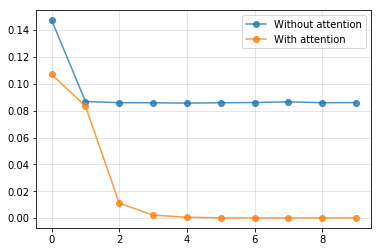

In [6]:
plt.plot(vanilla_model.history.history['loss'], 'o-', alpha=0.8, label='Without attention')
plt.plot(attention_model.history.history['loss'], 'o-', alpha=0.8, label='With attention')
plt.grid(alpha=0.4)
plt.legend()

# Visualizing attention weights

In [7]:
def copy_attention_model(model):    
    model_in = Input(shape=(None, 2), name='sequence-in')
    masked   = Masking(name='mask')(model_in)
    vectors  = LSTM(units=4, name='lstm', return_sequences=True, weights=model.layers[2].get_weights())(masked)

    attention = AttentionLayer(name='attention', return_attention=True, weights=model.layers[3].get_weights())(vectors)
    
    new_model = models.Model(inputs=[model_in], outputs=[attention])
    new_model.summary()

    return new_model

def plot_attention_graph(selected_samples, attention_coefs, selected_values):
    for sample_id, attention, y in zip(selected_samples, attention_coefs, selected_values):
        plt.figure(figsize=(20, 3))
        plt.title(f'Sample #{sample_id}. Correct value @ index {y}')
        plt.xlabel('Timesteps')
        plt.ylabel('Attention coefficient')

        plt.grid(alpha=0.4)
        plt.plot(attention)
        
        max_attention = np.max(attention)

        U = np.linspace(0, max_attention, 20)
        y = np.ones_like(U) * y
        plt.plot(y, U, 'r', alpha=0.8, label='Correct timestep')

        plt.legend()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     (None, None, 2)           0         
_________________________________________________________________
mask (Masking)               (None, None, 2)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 4)           112       
_________________________________________________________________
attention (AttentionLayer)   (None, None)              24        
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


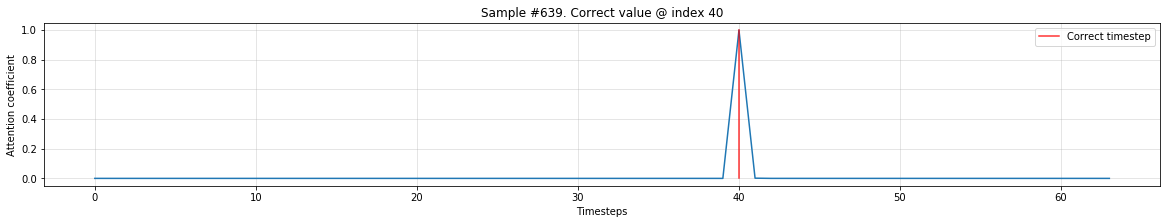

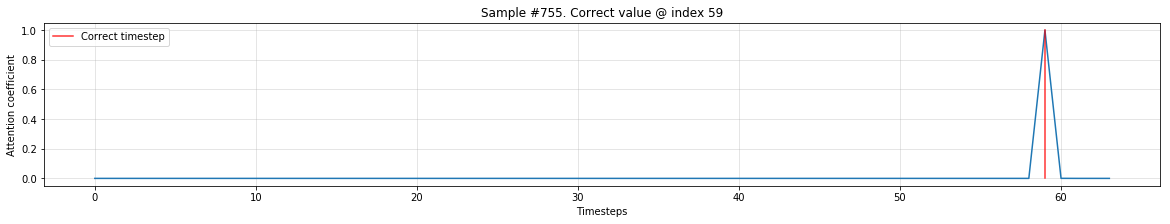

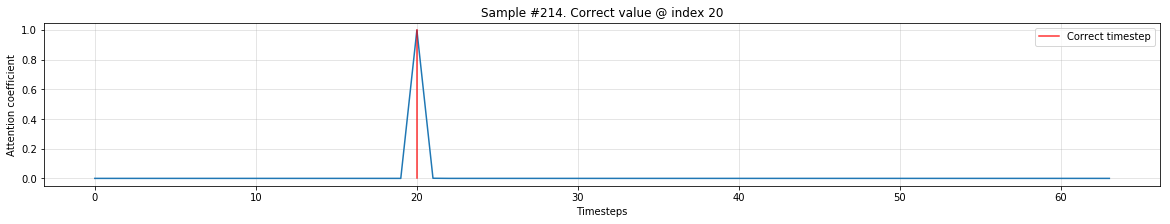

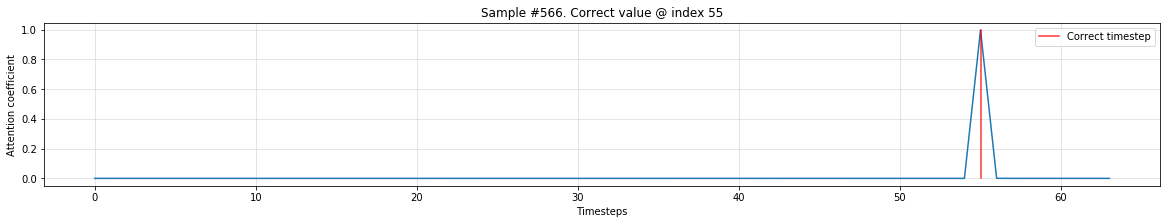

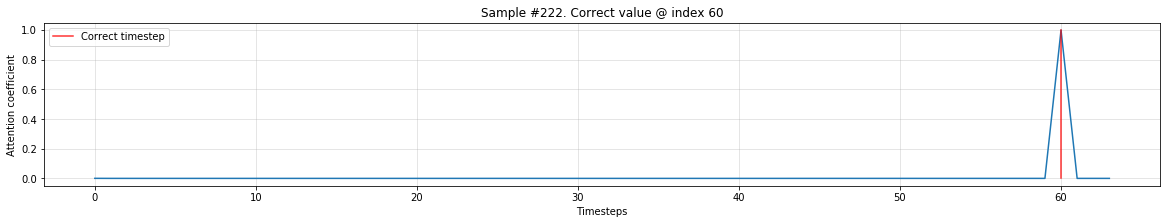

In [8]:
coef_model = copy_attention_model(attention_model)


N_PICKS = 5

selected_samples = np.random.randint(0, high=N_SAMPLES, size=N_PICKS)
selected_values  = correct_timesteps[selected_samples]
attention_coefs  = coef_model.predict(X[selected_samples])

plot_attention_graph(selected_samples, attention_coefs, selected_values)

# Training a model with attention layer and masking

Notice that the model is trained for fewer epochs to make the "bump" on the attention coefficients between the masked and non-masked regions visible. It's actually a bit harder to stop the training in a good spot by just changing the amount of epochs. If the loss is too low, the bump is not visible, if it is too high, the attention simply makes no sense.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     (None, None, 2)           0         
_________________________________________________________________
mask (Masking)               (None, None, 2)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 4)           112       
_________________________________________________________________
attention (AttentionLayer)   (None, 4)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0958 - mean_squared_error: 0.0958
Epoch 2/2
1000/1000 [============

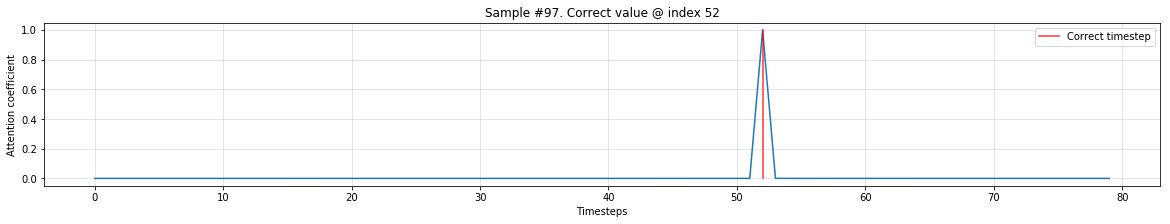

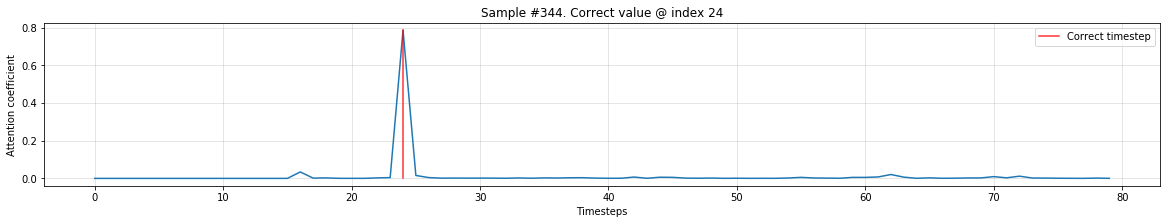

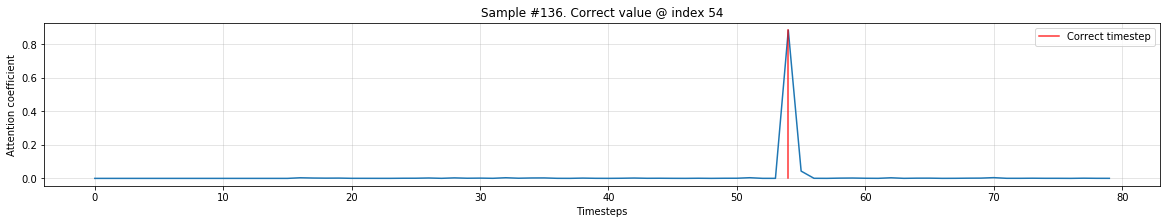

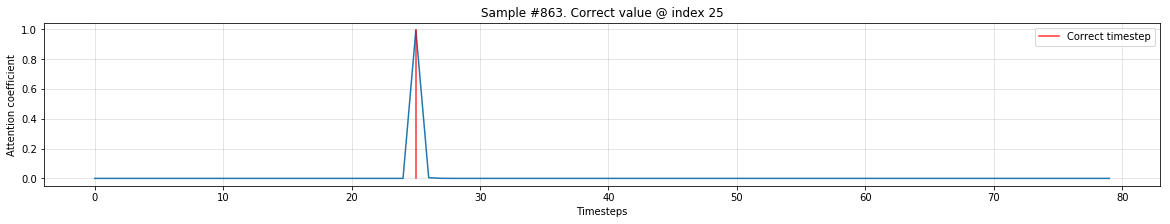

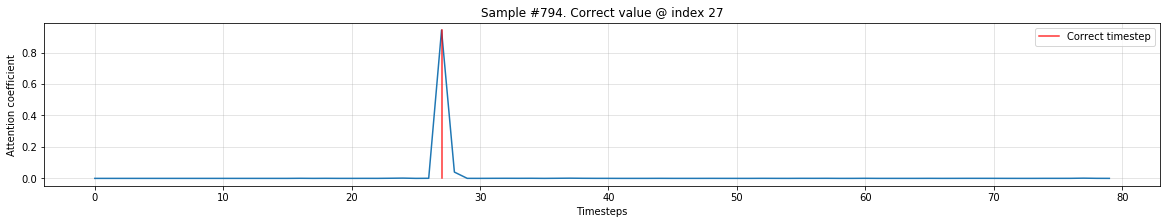

In [9]:
AMOUNT_BLANKS = 16

# prepending each sample is AMOUNT_BLANKS blank timesteps
O = np.zeros(shape=(1000, AMOUNT_BLANKS, 2))
O = np.concatenate((O, X), axis=1)

# training the model
masked_model = build_attention_model()
masked_model.fit(O, Y, batch_size=16, epochs=2)

# building the model to get the attention weights
masked_model_coefs = copy_attention_model(masked_model)

# picking some samples for visualization
selected_samples = np.random.randint(0, high=N_SAMPLES, size=N_PICKS)
selected_values  = correct_timesteps[selected_samples] + AMOUNT_BLANKS
attention_coefs  = masked_model_coefs.predict(O[selected_samples])

# plotting their attention weights
plot_attention_graph(selected_samples, attention_coefs, selected_values)